In [55]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [56]:
from sqlite3 import connect

## Opening the databases

In [57]:
def qry(q, connection = connect("database.sqlite")):
    df = pd.read_sql_query(q, connection)
    connection.close
    return df

The database consists of 4 tables: users, method, grade, ascent

In [58]:
tables = qry("SELECT name FROM sqlite_master")
tables

,name
0,user
1,method
2,grade
3,ascent


In [59]:
%%time
df_user = qry("SELECT * FROM USER")# 62'593 users x 22 columns
df_grade = qry("SELECT * FROM grade")# 83 grades x 14 columns
df_method = qry("SELECT * FROM method")# 5 methods x 4 columns
df_ascent = qry("SELECT * FROM ascent")# 4'111'877 ascents x 28 columns

CPU times: user 1min 9s, sys: 22.6 s, total: 1min 31s
Wall time: 1min 41s


&&&&&&&&&&&&&&&&&&&&&&&&&

In [60]:
df_user.columns

Index(['id', 'first_name', 'last_name', 'city', 'country', 'sex', 'height',
       'weight', 'started', 'competitions', 'occupation', 'sponsor1',
       'sponsor2', 'sponsor3', 'best_area', 'worst_area', 'guide_area',
       'interests', 'birth', 'presentation', 'deactivated', 'anonymous'],
      dtype='object')

In [61]:
df_grade.columns

Index(['id', 'score', 'fra_routes', 'fra_routes_input', 'fra_routes_selector',
       'fra_boulders', 'fra_boulders_input', 'fra_boulders_selector',
       'usa_routes', 'usa_routes_input', 'usa_routes_selector', 'usa_boulders',
       'usa_boulders_input', 'usa_boulders_selector'],
      dtype='object')

In [62]:
df_ascent.columns

Index(['id', 'user_id', 'grade_id', 'notes', 'raw_notes', 'method_id',
       'climb_type', 'total_score', 'date', 'year', 'last_year', 'rec_date',
       'project_ascent_date', 'name', 'crag_id', 'crag', 'sector_id', 'sector',
       'country', 'comment', 'rating', 'description', 'yellow_id', 'climb_try',
       'repeat', 'exclude_from_ranking', 'user_recommended', 'chipped'],
      dtype='object')

<b> climb type: 0 = sport, 1 = boulder </b>

In [63]:
df_method

,id,score,shorthand,name
0,1,0,redpoint,Redpoint
1,2,53,flash,Flash
2,3,145,onsight,Onsight
3,4,-52,toprope,Toprope
4,5,95,onsight,Onsight


In [64]:
%%time
df_grade.set_index('id', inplace = True) #Set the column 'id' to be the index.
df_ascent_id = df_ascent.set_index('id') #Set the column 'id' to be the index.

CPU times: user 2.1 s, sys: 6.36 s, total: 8.46 s
Wall time: 11.6 s


###### Grade ID

In [65]:
def grade_id(grade):
    """
    Given a grade (given as a string), returns its id number. 
    """
    row = 0
    exit = False 
    while not exit:
        line = df_grade.iloc[row].values
        if grade in line:
            exit = True 
            return df_grade.index[row]
        else: row = row +1

### Extracting active climbers

We extract the "active" climbers, i.e the users with recorded ascents, and define a dict called "logbook_active_users", whose keys are the active users, and values their ascents. <br/>

In [66]:
%%time
logbook = {} # First we cook up a "logbook" dict, with keys the climbers (users) and values the routes they sent.
for user in df_user['id']:
    logbook[user] = []
for route in df_ascent.itertuples():
    if getattr(route, 'user_id') in logbook:
        logbook[getattr(route, 'user_id')].append(getattr(route, 'id'))
    else:
        logbook[getattr(route, 'user_id')] = [getattr(route, 'id')]

CPU times: user 19 s, sys: 6.62 s, total: 25.6 s
Wall time: 27.6 s


In [67]:
print("There are") 
print(len(logbook),'-',df_user.shape[0],'=',len(logbook) - df_user.shape[0], 'users') 
print("""in the ascent database which do not correspond to anyone in the user database!! 
We have added these three mysterious climbers in the logbook dict""")

There are
62596 - 62593 = 3 users
in the ascent database which do not correspond to anyone in the user database!! 
We have added these three mysterious climbers in the logbook dict


In [68]:
logbook_active_users = {} # Getting rid in logbook of climbers with no recorded ascents
for user in logbook:
    if logbook[user] != []:
        logbook_active_users[user] = logbook[user]
print('There are', len(logbook_active_users), 'active climbers in the users database')

There are 36034 active climbers in the users database


In [69]:
active_user = [user for user in range(df_user.shape[0]) if df_user['id'][user] in logbook_active_users]
df_active_user = df_user.loc[active_user].set_index('id') # The dataframe of active users
df_active_user.shape

(36031, 21)

In [70]:
df_active_user.head()

,first_name,last_name,city,country,sex,height,weight,started,competitions,occupation,...,sponsor2,sponsor3,best_area,worst_area,guide_area,interests,birth,presentation,deactivated,anonymous
id,,,,,,,,,,,,,,,,,,,,,
1,first,last,Göteborg,SWE,0,177,73,1996,,,...,,,"Railay beach, Krabi, Thailand",None,,,1976-03-10,,0,0
2,first,last,stockholm,SWE,0,0,0,2000,,,...,,,,,,,None,,0,0
3,first,last,Umeå,SWE,0,180,78,1995,,,...,,,Hell,Umeå,,,1973-09-09,,0,0
4,first,last,Goteborg,SWE,1,165,58,2001,,,...,,,,None,,,1984-07-26,,0,0
5,first,last,North Attleboro,USA,0,0,0,1991,,,...,,,,None,,,1969-05-07,,0,0


### Extracting various years

In [71]:
def extract_year(Series, throw):
    """
    Given a Series of dates, replaces every occurance of 'throw' by a np.nan, and extract the year of the 
    admissible dates. 
    """
    for date in Series.index:
        if Series[date] == throw:
            Series[date] = np.nan
        else:
            S_year = Series[date].year
            Series[date] = S_year

##### Birthyears of active users

In [72]:
%%time
birthyears = pd.to_datetime(df_active_user['birth'],errors = 'coerce') 
#If ‘coerce’, then invalid parsing will be set as NaT
extract_year(birthyears, None)

CPU times: user 1.3 s, sys: 6.01 ms, total: 1.31 s
Wall time: 1.31 s


##### Years of ascends

In [73]:
# No funny things in the 'date' column of the ascent. It's either a unix timestamp or 0.
df_ascent['date'][(df_ascent['date'] !=0)].min()

315529200

In [74]:
pd.to_datetime(315529200, unit = 's').year

1979

In [75]:
%%time
sendyears = pd.to_datetime(df_ascent_id['date'], unit = 's')
extract_year(sendyears, pd.to_datetime(0, unit='s'))

CPU times: user 4min 55s, sys: 1.88 s, total: 4min 56s
Wall time: 5min 2s


In [76]:
sendyears[411123]

2006

##### Year started climbing

Some active users have starting year lower than their birth year! We compute how many such active climbers there are.  

In [81]:
startedyears = df_active_user['started'].replace(0, np.nan)

In [95]:
# Some non-sensical starting years! At least it's 0 or a year number. 
df_active_user['started'][(df_active_user['started'] !=0)].min()

1901

In [96]:
admissible = np.array([not value for value in (birthyears > startedyears)])
print('There are only',admissible.shape[0] - admissible.sum(), 'climbers with starting year lower than their birth year.' )

There are only 67 climbers with starting year lower than their birth year.


##### Age

In [82]:
age = 2017 - birthyears #Database is from 13th Sept 2017

In [116]:
age_nonan = age.values[[np.isfinite(a) for a in age.values]]
len(age_nonan)

21571

### Age and Age at which started climbing 

<function matplotlib.pyplot.show>

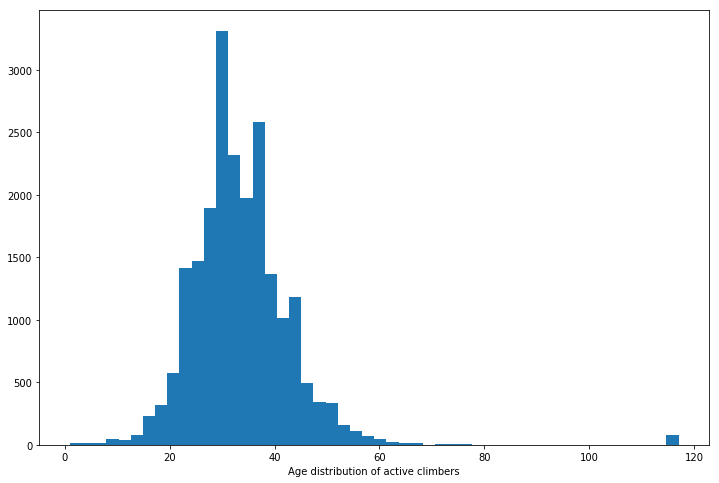

In [86]:
ages = age_without_nan.astype('float64')
plt.rcParams['figure.figsize'] = [12, 8]
plt.hist(ages,bins = 50)
plt.xlabel('Age distribution of active climbers')
plt.show

In [87]:
age_without_nan.mean()

33.576051179824766

In [88]:
age_without_nan.std()

9.755895975430299

In [89]:
age_started = startedyears - birthyears
age_started_nonan = age_started.values[[np.isfinite(a) for a in age_started.values]]

<function matplotlib.pyplot.show>

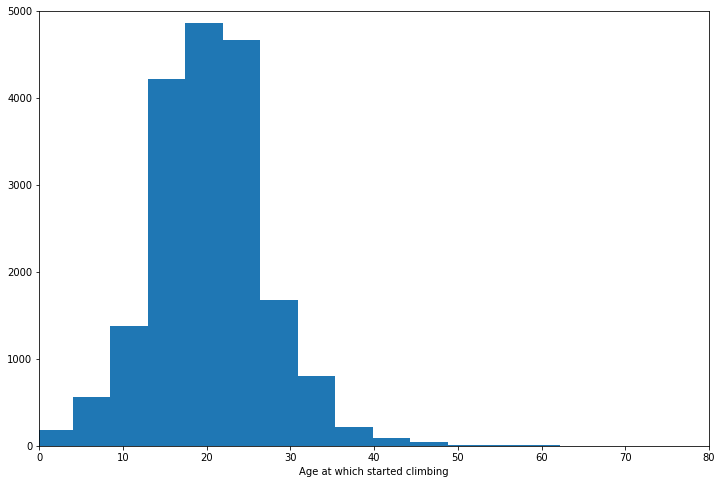

In [90]:
plt.hist(age_started_nonan.astype('float64'), bins = 50)
plt.axis([0, 80, 0, 5000])
plt.xlabel('Age at which started climbing')
plt.show

In [91]:
age_started_nonan.mean()

20.22596919808816

In [92]:
age_started_nonan.std()

8.1830216216531451

## Max grades with respect to physical characteristics

##### Maximum grades

In [114]:
%%time
#Maximum grades achieved by every active users
max_grades = [df_ascent[(df_ascent['user_id'] == user)]['grade_id'].max() for user in df_active_user.index]
max_grades_usa = [df_grade.loc[grade]['usa_routes'] for grade in max_grades]
df_maxgrades = pd.Series(max_grades, index = df_active_user.index)
df_maxgrades_usa = pd.Series(max_grades_usa, index = df_active_user.index)

CPU times: user 3min 33s, sys: 31.5 s, total: 4min 4s
Wall time: 4min 5s


###### Gender

I guess 1 is for female, but really this is not written anyhwere!

In [97]:
gender = df_active_user['sex']

In [102]:
print('There are', gender.sum(),'active female climbers.')

There are 6112 active female climbers.


###### Weight

In [153]:
weight = df_active_user['weight'].replace(0, np.nan)
weight_male = weight[(gender == 0)]
weight_female = weight[(gender == 1)]

In [154]:
weight_male_nonan = weight_male[[np.isfinite(w) for w in weight_male.values]]
weight_female_nonan = weight_female[[np.isfinite(w) for w in weight_female.values]]

In [155]:
maxgrades_vs_weight_male = df_maxgrades[weight_male_nonan.index]
maxgrades_vs_weight_female = df_maxgrades[weight_female_nonan.index]

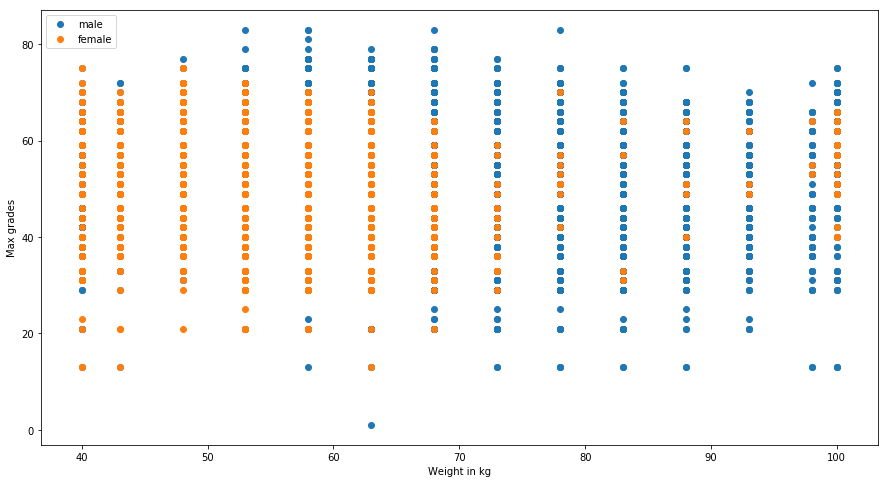

In [160]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.scatter(weight_male_nonan.astype('float64'), maxgrades_vs_weight_male.astype('float64'))
plt.scatter(weight_female_nonan.astype('float64'), maxgrades_vs_weight_female.astype('float64'))
plt.xlabel('Weight in kg')
plt.ylabel('Max grades')
plt.legend(['male', 'female'], loc = 2)

###### Height

In [133]:
height = df_active_user['height'].replace(0, np.nan)
height_male = height[(gender == 0)]
height_female = height[(gender == 1)]

In [134]:
height_male_nonan = height_male[[np.isfinite(h) for h in height_male.values]]
height_female_nonan = height_female[[np.isfinite(h) for h in height_female.values]]

In [139]:
maxgrades_vs_height_male = df_maxgrades[height_male_nonan.index]
maxgrades_vs_height_female = df_maxgrades[height_female_nonan.index]

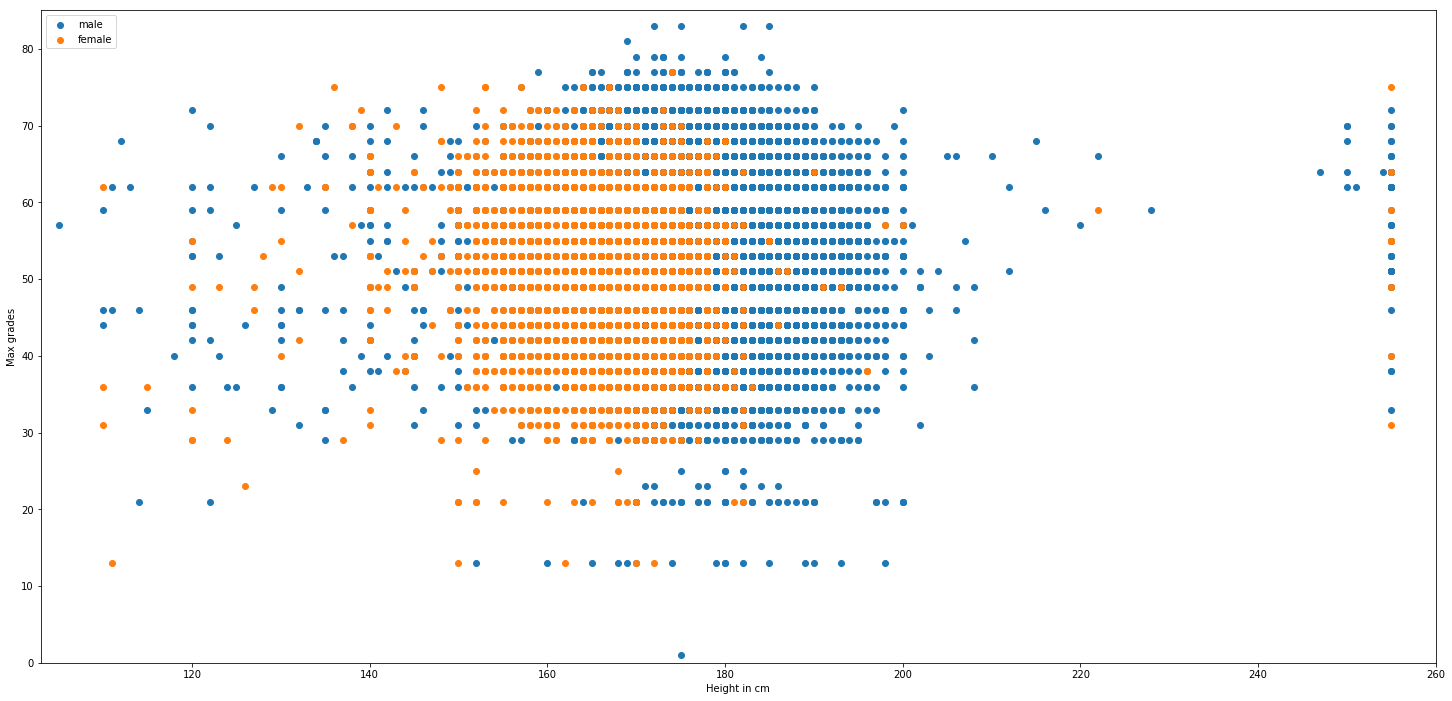

In [152]:
plt.rcParams['figure.figsize'] = [25, 12]
plt.scatter(height_male_nonan.astype('float64'), maxgrades_vs_height_male.astype('float64'))
plt.scatter(height_female_nonan.astype('float64'), maxgrades_vs_height_female.astype('float64'))
plt.axis([103, 260, 0, 85])
plt.xlabel('Height in cm')
plt.ylabel('Max grades')
plt.legend(['male', 'female'], loc = 2)

In [135]:
height_male_nonan.mean()

176.29969246540236

In [136]:
height_female_nonan.mean()

163.56105296542975

&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
<br>
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

## Average number of years to climb a grade

In [32]:
def achieve_grade(sample, grade, boulder = False):
    """
    Given a grade and a sample of active users, returns the average age and average number of climbing 
    years after which said grade was achieved. 
    Input:
    sample: A sub-dataframe of active users.
    grade: string
    boulder: boolean. False is sport, True is boulder (default = False)
    Output: (2,) array.  
    """
    result = []
    gradeid = grade_id(grade)
    for climber in sample.index:
        mask = (df_ascent_id['user_id'] == climber) & (df_ascent_id['grade_id'] == gradeid) & (df_ascent_id['climb_type'] == boulder)
        years = sendyears[mask].values
        if len(years) == 0 or pd.isnull(years).all():
            (age, nb_years) = (np.nan, np.nan)
        else:
            first_year = np.nanmin(years) #np.nanmin is min ignoring the nan's
            (age, nb_years) = (first_year - birthyears[climber], first_year - startedyears[climber])
        result.append([age, nb_years])
            
    return np.nanmean(np.array(result), axis = 0) #np.nanmean is mean ignoring the nan's

In [33]:
def achieve_grades(sample, grades, boulder = False):
    """
    Given a list of grades and a sample of active users, returns an np.array corresponding to the following:
    Every row corresponds to a grade; first column is average age; second column is average number of climbing years.
    """
    result = achieve_grade(sample, grades[0], boulder)
    for grade in grades[1:]:
        new_line = achieve_grade(sample, grade, boulder)
        result = np.vstack((result, new_line))
        
    return result

&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

In [34]:
usa_grades = [grade for grade in df_grade.loc[34:77,'usa_routes'] if grade != '']

In [57]:
sample = df_active_user.sample(n=1000)

In [58]:
%%time
average_achieve_grade = achieve_grades(sample, usa_grades)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


CPU times: user 12min 18s, sys: 4min 23s, total: 16min 41s
Wall time: 16min 58s


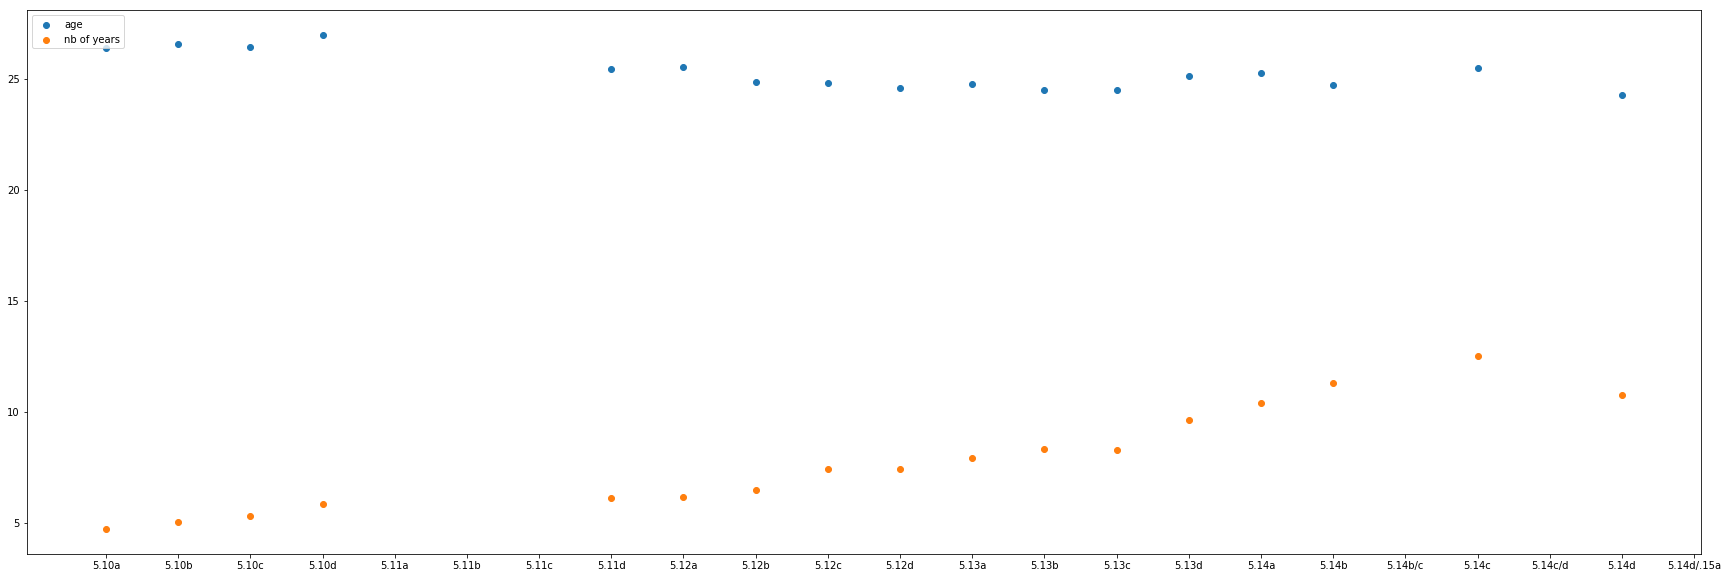

In [59]:
plt.rcParams['figure.figsize'] = [30, 10]
plt.scatter(usa_grades, average_achieve_grade[:,0])
plt.scatter(usa_grades, average_achieve_grade[:,1])
plt.legend(['age', 'nb of years'], loc = 2)

In [57]:
started_after_25 = df_active_user[(age_started > 25)]
started_after_25.shape

(3550, 21)

In [62]:
sample = started_after_25.sample(n = 500)

In [63]:
%%time
average_achieve_grade = achieve_grades(sample, usa_grades)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


CPU times: user 6min, sys: 1min 40s, total: 7min 41s
Wall time: 7min 45s


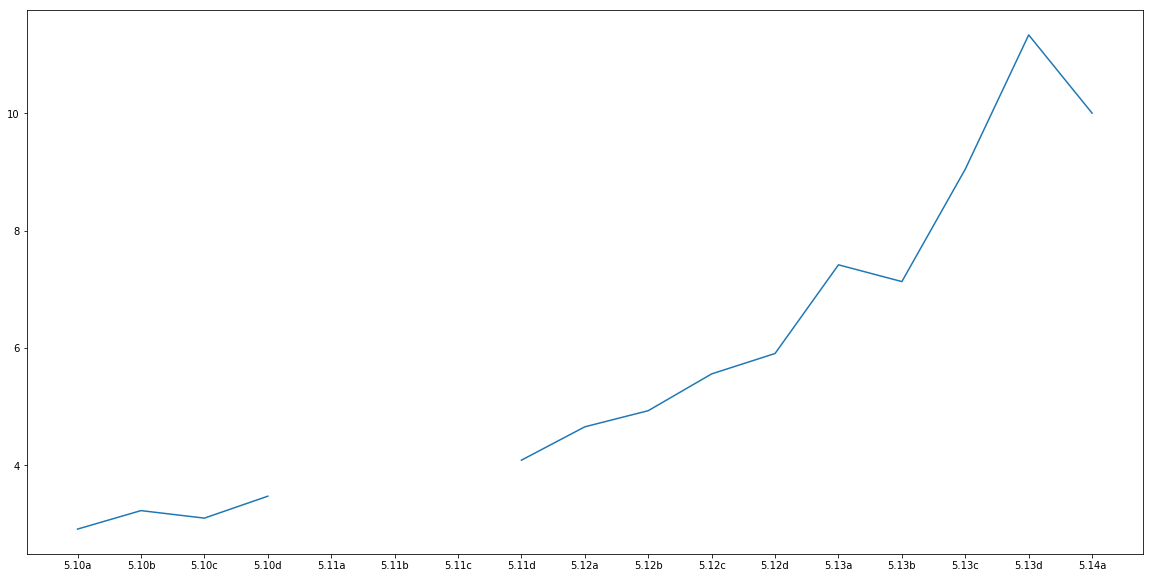

In [68]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(usa_grades, average_achieve_grade[:,1])

In [35]:
started_after_30 = df_active_user[(age_started > 30)]
started_after_30.shape

(1223, 21)

In [36]:
sample2 = started_after_30.sample(n = 500)

In [37]:
%%time
average_achieve_grade = achieve_grades(sample2, usa_grades)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


CPU times: user 6min 24s, sys: 2min 8s, total: 8min 33s
Wall time: 8min 38s


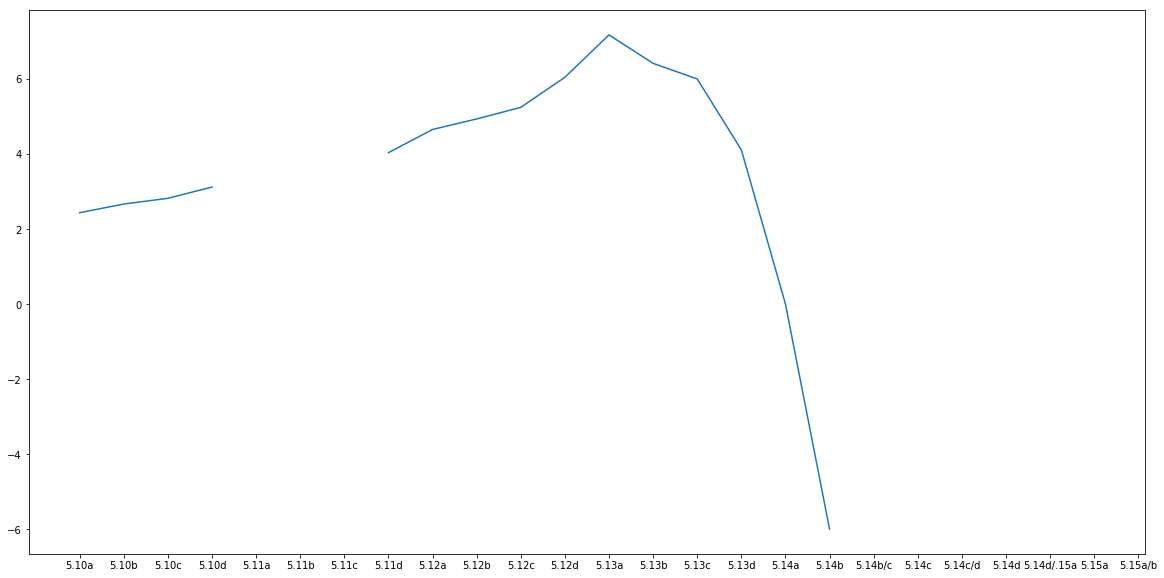

In [38]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(usa_grades, average_achieve_grade[:,1])